# IMF sampling - A code to optimally sample (varying) stellar IMFs

This code provided in this notebook makes it possible to generate IMF samples from a canonical as well as a varying stellar IMF form, using optimal sampling. This code was written using the supplementary.pdf document from the galIMF module ([Yan et al. 2017](https://www.aanda.org/articles/aa/full_html/2017/11/aa30987-17/aa30987-17.html)), which can be found on GitHub under https://github.com/Azeret/galIMF.

## Theoretical background

### Distinction between IMF and stellar IMF

The **initial mass function (IMF)**, $\xi(m)$, describes the number distribution of initial stellar masses in a stellar population. It is defined as
$$
\begin{equation}\xi(m)=\frac{d N}{d m} \, ,
\end{equation}
$$
with $d N$ the number of stars in the mass interval $[m, m + d m]$.\
The general form of the IMF is
$$
\begin{equation}\xi(m)=\frac{d N}{d m}=km^{-\alpha} \, ,
\end{equation}
$$
with $k$ as a normalization constant.

The **stellar IMF** is a special type of IMF. It describes the stellar population of a single embedded cluster, born from one molecular cloud clump. \
This is opposed to a **composite IMF (cIMF)** which describes a stellar population that consists of stars from various embedded clusters. An example for a composite IMF is the Salpeter IMF, that describes the IMF of stars in the Solar neighborhood, independent of whether the stars were all birthed in the same star cluster.\
The composite IMF of a whole galaxy is called **galaxy-wide IMF (gwIMF)**.


### The theoretical formulations used in this code

This code uses the general form of a Kroupa IMF, which is given as

$\xi(m) = \cases{m^{-\alpha_1}\quad \mathrm{for}\,\, 0.08 \leq \frac{m}{M_{\odot}} <0.5 \\
m^{-\alpha_2}\quad \mathrm{for}\,\, 0.5 \leq \frac{m}{M_{\odot}} <1.0 \\
m^{-\alpha_3}\quad \mathrm{for}\,\, 1.0 \leq \frac{m}{M_{\odot}} <m_{\mathrm{max}}} $

where for the canonical case, $\alpha_1=1.3, \alpha_2= 2.3$ and $\alpha_3=2.3$.

The environmentally varying IMF used also in the IGIMF Theory is defined in [Yan et al. (2021)](https://www.aanda.org/articles/aa/full_html/2021/11/aa40683-21/aa40683-21.html) in the following way

The dependence of the IMF on metallicity and density is such that

$$
\begin{aligned}
& \alpha_1 = 1.3 + \Delta \alpha (Z - Z_{\odot}), \quad \quad 0.08\leq m/M_{\odot} < 0.5 \, , \\ 
& \alpha_2 = 2.3 + \Delta \alpha (Z - Z_{\odot}), \quad \quad 0.5\leq m/M_{\odot} < 1.0 \, ,
\end{aligned}
$$

with $Z$ the metallicity of the targeted system and and $Z_{\odot}=0.0142$ the solar metallicity.
For this solar metallicity ([Yan et al. 2021](https://www.aanda.org/articles/aa/full_html/2021/11/aa40683-21/aa40683-21.html)) empirically determined a value of $\Delta \alpha = 63$.

$$
\begin{aligned}
& \alpha_3 = \begin{cases} 
 2.3, x < -0.87, \\
-0.41x +1.94, x >-0.87
\end{cases} \quad 1.0\leq m/M_{\odot}< m_{\mathrm{max}}\, , \\
& x= -0.14[Z] + 0.99 \log_{10}(\rho_{\mathrm{cl}}/(10^6))\, ,
\end{aligned}
$$

with $\log_{10}(\rho_{\mathrm{cl}}) = 0.61 \log_{10}(M_{\mathrm{ecl}}) + 2.85$, where $\rho_{\mathrm{cl}}$ represents the density of the cluster.\
For the metallicity $[Z/X] = \log_{10}(Z/X)-\log_{10}(Z_{\odot}/X_{\odot})$, one can assume the initial hydrogen mass fraction $X$ of any star to be the same as in the sun ($X_{\odot} \approx X$) leading to $[Z/X] \approx \log_{10}(Z/Z_{\odot}) = [Z]$.\
The higher the density in a region or the lower the metallicity, the smaller $\alpha_3$ becomes. This is equivalent to an excess of massive stars compared to a Kroupa IMF. The stellar IMF becomes top-heavy.\
Note, that since the cluster density scales with cluster mass, this means that more massive clusters have top-heavier stellar IMFs. 

## Inputs for the most important IMF models

There are several IMF models already implemented from which data can be generated using optimal sampling. In order to set a model, the inputs **alpha_i_model**, with i={1,2,3}, need to be defined.

For a canonical IMF, simply use:

alpha_1_model=0 \
alpha_2_model=0 \
alpha_3_model=0

For the varying IMF, typically used within the IGIMF Theory and defined within [Yan et al. (2021)](https://www.aanda.org/articles/aa/full_html/2021/11/aa40683-21/aa40683-21.html) use:

alpha_1_model='Z' \
alpha_2_model='Z' \
alpha_3_model= 2

## Other inputs

In order to generate data, the code further needs the **(embedded) cluster mass $M_{\mathrm{ecl}}$** as well as the metallicity **M_over_H** of the molecular cloud in terms of **[Z]** as input. 

$M_{\mathrm{ecl}}$ is equal to the total **stellar** mass formed, i.e. the desired stellar mass formed from the molecular cloud. The algorithm will return a sample of stellar masses that is as close as possible to $M_{\mathrm{ecl}}$, following the pre-defined IMF.

## Necessary functions to initialize

The upper integration limit of the IMF $m_{\mathrm{max}}$ (which is not equal to the physical limit, which is $M_U=150\,M_{\odot}$!) needs to be found via the functions **find_m_max_i**, with i={1,2,3}, that can determine $m_{\mathrm{max}}$ given the cluster mass and IMF model as input. 

The function **model_IMF_m** defined the analytical function $\xi(m)\times m$ and is needed to determine the stellar masses.

In [1]:
from scipy.optimize import root_scalar
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.integrate

## Necessary functions to draw stellar masses

####### Defining the IMF form

## In order to sample an IMF form needs to be chosen. Here, a Kroupa IMF is used.
## function_alpha_i_change gives the value alpha_i of the IMF slope.

### function alpha_1_change(alpha_1, alpha1_model, M_over_H) imported from galimf.py
def function_alpha_1_change(alpha1_model, M_over_H):
    alpha_1 = 1.3
    if (alpha1_model == 0):
        return alpha_1
    elif (alpha1_model == 1):
        alpha_1_change = alpha_1 + 0.5 * M_over_H
        return alpha_1_change
    elif (alpha1_model == 'IGIMF2.5'):
        alpha_1_change = alpha_1 + 0.12 * M_over_H
        return alpha_1_change
    elif (alpha1_model == 'Z_MW'):
        alpha_1_change = alpha_1 + 79.4 * (10**M_over_H - 10**(-0.1)) * 0.0142
        return alpha_1_change
    elif (alpha1_model == 'Z'):
        alpha_1_change = alpha_1 + 63 * (10**M_over_H - 1) * 0.0142
        return alpha_1_change
    else:
        print('Invalid Input for alpha1 model')
        return

## Function to change alpha_2 depending on the model; imported from galimf.py
def function_alpha_2_change(alpha2_model, M_over_H):
    alpha_2=2.3
    if (alpha2_model == 0):
        return alpha_2
    elif (alpha2_model == 1):
        alpha_2_change = alpha_2 + 0.5 * M_over_H
        return alpha_2_change
    elif (alpha2_model == 'Z_MW'):
        alpha_2_change = alpha_2 + 79.4 * (10**M_over_H - 10**(-0.1)) * 0.0142
        if M_over_H>1:
            print("Warning: Abnormally high gas metallicity leading to an unrealistic IMF shape according to the assumed variation law: alpha2_model == 'Z'. Please check your galaxy evolution settings or change to a different IMF variation assumption.")
        return alpha_2_change
    elif (alpha2_model == 'Z'):
        alpha_2_change = alpha_2 + 63 * (10**M_over_H - 1) * 0.0142
        if M_over_H>1:
            print("Warning: Abnormally high gas metallicity leading to an unrealistic IMF shape according to the assumed variation law: alpha2_model == 'Z'. Please check your galaxy evolution settings or change to a different IMF variation assumption.")
        return alpha_2_change
    elif (alpha2_model == 'IGIMF2.5'):
        alpha_2_change = alpha_2 + 0.12 * M_over_H
        return alpha_2_change
    elif (alpha2_model == 'R14'):
        alpha_2_change = 2.3 + 0.0572 * M_over_H
        return alpha_2_change
    else:
        print('Invalid input for alpha2 model')
        return

## Function to change alpha_3 depending on the model; imported from galimf.py
def function_alpha_3_change(alpha3_model, M_ecl, M_over_H):
    ## M_ecl is the mass of the cluster
    ## M_over_H is the metallicity of the cluster in [Z]
    ## alpha3_model is the model for the IMF power-index for M_turn2 < M < M_str_U
    if (alpha3_model == 0):
        default_alpha3 = 2.3
        # print("alpha_3 is set to be a constant: %s, as this is the default alpha_3 value for alpha3_model 0.\nFor more options regarding alpha_3 variation, please check file 'alpha3.py'" % (default_alpha3))
        return default_alpha3
    elif (alpha3_model == 1):
        rho = 10 ** (0.61 * math.log(M_ecl, 10) + 2.85)
        if rho < 9.5 * 10 ** 4:
            alpha_3_change = 2.3
        else:
            alpha_3_change = 1.86 - 0.43 * math.log(rho / 10 ** 6, 10)
        # print("Notification in file 'alpha3_model' uncompleted")
        if alpha_3_change < 0.5:
            print("IMF alpha_3 being", alpha_3_change, "out of the tested range from Marks et al. 2012.")
        return alpha_3_change
    elif (alpha3_model == 2):
        rho = 10 ** (0.61 * math.log(M_ecl, 10) + 2.85)
        x = -0.14 * M_over_H + 0.99 * math.log(rho / 10 ** 6, 10)
        if x < -0.87:
            alpha_3_change = 2.3
        else:
            alpha_3_change = -0.41 * x + 1.94
        # print("Notification in file 'alpha3_model' uncompleted")
        return alpha_3_change
    elif (alpha3_model == 'R14'):
        alpha_3_change = 2.3 + 0.0572 * M_over_H
        return alpha_3_change
    else:
        print('Invalid input for alpha_3 model')
        return alpha3_model


## Find m_max for a given M_ecl; m_max is the upper integration limit for the most massive star in the cluster
## m_max is NOT the mass of the most massive star in the cluster!

## Make finding m_max into a function
## M_ecl is the mass of the cluster 
## alpha_1_model, alpha_2_model, alpha_3_model are the models for the IMF powerlaw indices
## M_over_H is the metallicity of the cluster in terms of [Z]

def find_m_max(M_ecl, alpha_1_model, alpha_2_model, alpha_3_model, M_over_H):
    M_str_L = 0.08  # star mass lower limit [solar mass]
    M_str_U = 150.0  # star mass upper limit [solar mass]
    M_turn = 0.5  # IMF power-index breaking mass [solar mass]
    M_turn2 = 1.0  # IMF power-index breaking mass [solar mass]

    I = 1.0 ## I=I_str

    alpha_1 = function_alpha_1_change(alpha_1_model, M_over_H)  # IMF power-index for M_str_L < M < M_turn
    alpha_2 = function_alpha_2_change(alpha_2_model, M_over_H)  # IMF power-index for M_turn < M < M_turn2
    alpha_3 = function_alpha_3_change(alpha_3_model, M_ecl, M_over_H)  # IMF power-index for M_turn2 < M < M_str_U

    def Max(M_max):
        eq1 = M_ecl * M_str_U**(1-alpha_3) / (I * (1-alpha_3)) - M_turn2**(alpha_2-alpha_3) * M_turn**(alpha_1-alpha_2) / (2-alpha_1) * (M_turn**(2-alpha_1) - M_str_L**(2-alpha_1)) - M_turn2**(alpha_2-alpha_3) / (2-alpha_2) * (M_turn2**(2-alpha_2) - M_turn**(2-alpha_2)) + M_turn2**(2-alpha_3) / (2-alpha_3)
        eq2 = M_max**(2-alpha_3) / (2-alpha_3) + M_ecl * M_max**(1-alpha_3) / (I * (1-alpha_3))
        return eq1 - eq2
    
    sol = root_scalar(Max, bracket=[M_str_L, 0.9999*M_str_U])
    M_max = sol.root
    return M_max

### find m_max function for Mturn< m_max < Mturn_2 
###(only possible for lowest possible star cluster mass <2.72 solarmasses)
def find_m_max_2(M_ecl, alpha_1_model, alpha_2_model, alpha_3_model, M_over_H):
    M_str_L = 0.08  # star mass lower limit [solar mass]
    M_str_U = 150.0  # star mass upper limit [solar mass]
    M_turn = 0.5  # IMF power-index breaking mass [solar mass]
    M_turn2 = 1.0  # IMF power-index breaking mass [solar mass]

    I = 1.0

    alpha_1 = function_alpha_1_change(alpha_1_model, M_over_H)  # IMF power-index for M_str_L < M < M_turn
    alpha_2 = function_alpha_2_change(alpha_2_model, M_over_H)  # IMF power-index for M_turn < M < M_turn2
    alpha_3 = function_alpha_3_change(alpha_3_model, M_ecl, M_over_H)  # IMF power-index for M_turn2 < M < M_str_U

    def Max_2(M_max):
        eq1 = M_max**(2-alpha_2)/(2-alpha_2)+M_ecl*M_max**(1-alpha_2)/(I*(1-alpha_2))
        eq2 = M_ecl*M_turn2**(1-alpha_2)/(I*(1-alpha_2))+M_ecl*M_turn2**(alpha_3-alpha_2)/(I*(1-alpha_3))*(M_str_U**(1-alpha_3)-M_turn2**(1-alpha_3))-M_turn**(alpha_1-alpha_2)/(2-alpha_1)*(M_turn**(2-alpha_1)-M_str_L**(2-alpha_1))+M_turn**(2-alpha_2)/(2-alpha_2)
        return eq1 - eq2
    
    sol = root_scalar(Max_2, bracket=[M_str_L, 0.9999*M_str_U])
    M_max = sol.root
    return M_max


### find m_max function for m_max < Mturn
### unrealistic for most cases, but still implemented for completeness
def find_m_max_3(M_ecl, alpha_1_model, alpha_2_model, alpha_3_model, M_over_H):
    M_str_L = 0.08  # star mass lower limit [solar mass]
    M_str_U = 150.0  # star mass upper limit [solar mass]
    M_turn = 0.5  # IMF power-index breaking mass [solar mass]
    M_turn2 = 1.0  # IMF power-index breaking mass [solar mass]

    I = 1.0

    alpha_1 = function_alpha_1_change(alpha_1_model, M_over_H)  # IMF power-index for M_str_L < M < M_turn
    alpha_2 = function_alpha_2_change(alpha_2_model, M_over_H)  # IMF power-index for M_turn < M < M_turn2
    alpha_3 = function_alpha_3_change(alpha_3_model, M_ecl, M_over_H)  # IMF power-index for M_turn2 < M < M_str_U

    def Max_3(M_max):
        eq1 = M_max**(2-alpha_1)/(2-alpha_1)+M_ecl*M_max**(1-alpha_1)/(I*(1-alpha_1))
        eq2 = M_ecl*M_turn**(1-alpha_1)/(I*(1-alpha_1))+M_ecl*M_turn**(alpha_2-alpha_1)/(I*(1-alpha_2))*(M_turn2**(1-alpha_2)-M_turn**(1-alpha_2))+M_ecl*M_turn2**(alpha_3-alpha_2)*M_turn**(alpha_2-alpha_1)/(I*(1-alpha_3))*(M_str_U**(1-alpha_3)-M_turn2**(1-alpha_3))+M_str_L**(2-alpha_1)/(2-alpha_1)
        return eq1 - eq2

    sol = root_scalar(Max_3, bracket=[M_str_L, 0.9999*M_str_U])
    M_max = sol.root
    return M_max


## IMF function*m with prefactor. Can be used to determine Masses M_i
def model_IMF_m(m, alpha_1_model, alpha_2_model, alpha_3_model, M_ecl, M_over_H, k3):
    M_str_L = 0.08  # star mass lower limit [solar mass]
    M_str_U = 150.0  # star mass upper limit [solar mass]
    M_turn = 0.5  # IMF power-index breaking mass [solar mass]
    M_turn2 = 1.  # IMF power-index breaking mass [solar mass]

    alpha_1 = function_alpha_1_change(alpha_1_model, M_over_H)  # IMF power-index for M_str_L < M < M_turn
    alpha_2 = function_alpha_2_change(alpha_2_model, M_over_H)  # IMF power-index for M_turn < M < M_turn2
    alpha_3 = function_alpha_3_change(alpha_3_model, M_ecl, M_over_H) #IMF power-index for M_turn2 < M < M_str_U

    ## distinction between cases; IMF is three-part power-law
    if m < M_str_L:
        return 0
    if M_str_L < m < M_turn:
        ### becomes relevant when M_turn and M_turn_2 take different values
        #k1 = M_turn2**(alpha_2-alpha_3) * M_turn**(alpha_1-alpha_2)*k3 
        ### When M_turn=0.5 and M_turn2=1.0, k1 simplifies to:
        k1=M_turn**(alpha_1-alpha_2)*k3

        return k1 * m**(1-alpha_1)
    if M_turn < m < M_turn2:
        ### becomes relevant when M_turn and M_turn_2 take different values
        #k2 = M_turn2**(alpha_2-alpha_3)*k3 
        ### When M_turn=0.5 and M_turn2=1.0, k2 simplifies to:
        k2= 1.0*k3 ## k2=k3
        return k2 * m**(1-alpha_2)
    if M_turn2 < m < M_str_U:
        return k3*m**(1-alpha_3) ##
    if m > M_str_U:
        return 0

## MLE for powerlaws

We are also initializing a maximum likelihood estimator (MLE) for powerlaws to check, that the slopes of the drawn samples are actually close to the theoretical values. This powerlaw MLE is based on [Maschberger & Kroupa (2009)](https://academic.oup.com/mnras/article/395/2/931/1747409).

It returns the estimate and its standard error as: (estimate, error estimate)

In [2]:
def MLE_with_std(data):

    Y=np.min(data)
    Z=np.max(data)
    T=np.sum(np.log(data))
    n=len(data)

    ## Does this really determine the exponent I look for?
    def Determinator(alpha_ML):  
        eq1 = -n/(1-alpha_ML)
        eq2 = n*(Z**(1-alpha_ML)*np.log(Z)-Y**(1-alpha_ML)*np.log(Y))/(Z**(1-alpha_ML)-Y**(1-alpha_ML))-T
        return eq1+eq2
        
    sol = root_scalar(Determinator, bracket=[-30.0, 0.999*30.0])
    slope = sol.root
    slope_unbiased=(n)/(n-2)*(slope-1)+1 ## According to Maschberger& Kroupa (2009)


    Fisher_information=n*(slope_unbiased/(1-slope_unbiased)**2+(Y**(1-slope_unbiased)*Z**(1-slope_unbiased)*((np.log(Z)-np.log(Y))**2))/(Z**(1-slope_unbiased)-Y**(1-slope_unbiased))**2)

    Variance=1/(n*Fisher_information)
    SE=np.sqrt(Variance) ### This is the standard error!! Not the standard deviation!
    std=np.sqrt(1/Fisher_information)


    return slope_unbiased, std

### The sampling function

This function can draw stellar masses from different types of IMF, especially the varying IMF from [Yan et al. (2021)](https://www.aanda.org/articles/aa/full_html/2021/11/aa40683-21/aa40683-21.html). For this it needs the mass of the (embedded) cluster **M_ecl**, the IMF form (**alpha_i_model**, with i={1,2,3}) and the metallicity [Z] (**M_over_H**) as input, as some varying IMFs depend on metallicity.

In [3]:
### IMF sampling function

### Needs mass of the embedded cluster (M_ecl), 
### the IMF model for the IMF powerlaw indices (alpha_1_model, alpha_2_model, alpha_3_model)
### and the metallicity of the cluster (M_over_H) as input

def draw_imf(M_ecl, alpha_1_model, alpha_2_model, alpha_3_model, M_over_H):
    M_str_L = 0.08  # star mass lower limit [solar mass]
    M_str_U = 150.0  # star mass upper limit [solar mass]
    M_turn = 0.5  # IMF power-index breaking mass [solar mass]
    M_turn2 = 1.  # IMF power-index breaking mass [solar mass]
    I_str=1. #normalization factor in the Optimal Sampling condition equation (says that integral from mmax to M_str_U of IMF is equal to 1; one star in that mass range)
    ## Per definition: I_str = scipy.integrate.quad(function_IMF(m), M_max, M_str_U)[0]

    ## Definition of alpha_1 and alpha_2
    alpha_1=function_alpha_1_change(alpha_1_model, M_over_H) #IMF power-index for M_str_L < M < M_turn
    alpha_2=function_alpha_2_change(alpha_2_model, M_over_H) #IMF power-index for M_turn < M < M_turn2

    ## alpha_3 is assumed to vary with metallicity and cluster mass
    alpha_3=function_alpha_3_change(alpha_3_model, M_ecl, M_over_H) #IMF power-index for M_turn2 < M < M_str_U


    ## find m_max by using root_scalar
    ## m_max=m_1 is the upper integration limit for the most massive star in the cluster
    ## It is NOT the mass of the most massive star in the cluster!

    ## upper integration limit for cluster of mass M_ecl is found by using the Optimal Sampling condition
    ## m_max is calculated using the standard case, that M_turn2 < m_max < M_str_U
    m_max=find_m_max(M_ecl, alpha_1_model, alpha_2_model, alpha_3_model, M_over_H)
    #print('m_max=', m_max)

    m_i=m_max

    ### m_i and m_i+1 are not the stellar masses, but only the upper and lower limits of the mass intervals
    ### from which the masses M_i are drawn

    ### draw all other stars with the conditions stated in supplementary document
    ### m_i_array is the array of all integration limits for the stars in the cluster
    m_i_array = np.array([])
    m_i_array=np.append(m_i_array,m_i)

    ### Array for all Masses M_i that are drawn with help of the integration limits m_i
    M_i_array = np.array([])

    ### Masses M_i are determined by integral from m_i+1 to m_i over m*IMF(m)

    ## calculate the normalization factor k3 by using the upper integration limit m_max
    if M_turn2 < m_max < M_str_U:
        ## Under the assumption that M_turn2 < m_max, k3 can be calculated by the following equation
        ## This is the case for M_ecl<2.72 solar masses
        k3= I_str*(1-alpha_3)/(M_str_U**(1-alpha_3)-m_max**(1-alpha_3))

    ## when m_max is smaller than M_turn2, the m_max has to be recalculated
    ## transition from case 1 to case 2 is smooth, as both are equal, when m_max=M_turn2
    elif m_max < M_turn2:
        ## recalculate the m_max, if it is smaller than M_turn2
        m_max=find_m_max_2(M_ecl, alpha_1_model, alpha_2_model, alpha_3_model, M_over_H)
        #print('m_max_2=',m_max)
        if M_turn < m_max < M_turn2:
            m_i=m_max
            m_i_array = np.array([])
            m_i_array=np.append(m_i_array,m_i)
    
            k3= I_str*(M_turn2**(alpha_2-alpha_3)/(1-alpha_2)*(M_turn2**(1-alpha_2)-m_max**(1-alpha_2))+1/(1-alpha_3)*(M_str_U**(1-alpha_3)-M_turn2**(1-alpha_3)))**(-1)
    
            ## k3 can be calculated using the model_IMF function by integrating from m_max to M_str_U
            ## The optimal sampling condition is, that only one star can be equal or more massive than m_max
            ## Therefore, the integral from m_max to M_str_U has to be equal to 1
            
        ## when m_max is smaller than M_turn, the m_max has to be recalculated
        ## transition from case 2 to case 3 is smooth, as both are equal, when m_max=M_turn
        elif m_max < M_turn:
            m_max=find_m_max_3(M_ecl, alpha_1_model, alpha_2_model, alpha_3_model, M_over_H)
            #print('m_max_3=', m_max)
            m_i=m_max
            m_i_array = np.array([])
            m_i_array=np.append(m_i_array,m_i)
    
            k3= I_str*(M_turn2**(alpha_2-alpha_3)*M_turn**(alpha_1-alpha_2)/(1-alpha_1)*(M_turn**(1-alpha_1)-m_max**(1-alpha_1))+M_turn2**(alpha_2-alpha_3)/(1-alpha_2)*(M_turn2**(1-alpha_2)-M_turn**(1-alpha_2))+1/(1-alpha_3)*(M_str_U**(1-alpha_3)-M_turn2**(1-alpha_3)))**(-1)

        ### if m_max cannot be found something went wrong in the calculation of m_max
        else:
            print('m_max could not be found')
            return

    ## k1 and k2 relate to k3 like this due to boundary conditions
    #k1 = M_turn2**(alpha_2-alpha_3) * M_turn**(alpha_1-alpha_2) * k3
    #k2 = M_turn2**(alpha_2-alpha_3) * k3

    ## When plugging in M_turn=0.5 and M_turn_2 = 1.0, k1 and k2 simplify to:
    ##k1=2*k3 ## This is only true in the canonical case!!

    k1=M_turn**(alpha_1-alpha_2)*k3
    k2=k3 ## This is only true, if M_turn2=1.0

    ## let loop run while the lower integration limit is larger than M_str_L
    while m_i > 0.08:

        ## General idea: m_i is known and I want to find m_i+1
        ## I can calculate m_i+1 with the conditions stated in the supplementary document
        ## that the integral between m_i and m_i+1 over the IMF is equal to 1.
        ## From the m_i+1, the mass M_i can be determined by integrating the IMF*m from m_i+1 to m_i

        if  M_turn2 < m_i < M_str_U:
            ## can either be case 1 or 2
            m_i_1=(m_i**(1-alpha_3)-(1-alpha_3)/(k3))**(1/(1-alpha_3)) #Case 1
            m_i_2=(M_turn2**(1-alpha_2)+k3/k2*(1-alpha_2)/(1-alpha_3)*(m_i**(1-alpha_3)-M_turn2**(1-alpha_3))-(1-alpha_2)/k2)**(1/(1-alpha_2)) #Case 2
            if M_turn2 < m_i_1 < m_i < M_str_U:
                m_i_array=np.append(m_i_array,m_i_1)
                ### with calculated m_i+1, the mass M_i can be determined by integrating the IMF from m_i+1 to m_i
                M_i= (scipy.integrate.quad(model_IMF_m, m_i_1, m_i, args=(alpha_1_model, alpha_2_model, alpha_3_model, M_ecl, M_over_H, k3))[0])
                M_i_array=np.append(M_i_array,M_i)
                m_i=m_i_1
            
            elif M_turn < m_i_2 < M_turn2:
                m_i_array=np.append(m_i_array,m_i_2)
                ### with calculated m_i+1, the mass M_i can be determined by integrating the IMF from m_i+1 to m_i
                M_i= (scipy.integrate.quad(model_IMF_m, m_i_2, m_i, args=(alpha_1_model, alpha_2_model, alpha_3_model, M_ecl, M_over_H, k3))[0])
                M_i_array=np.append(M_i_array,M_i)
                m_i=m_i_2
            else:
                print("Error")
                break
        elif M_turn < m_i < M_turn2:
            ## can either be case 3 or 4
            m_i_3=(m_i**(1-alpha_2)-(1-alpha_2)/k2)**(1/(1-alpha_2))
            m_i_4=(M_turn**(1-alpha_1)+k2/k1*(1-alpha_1)/(1-alpha_2)*(m_i**(1-alpha_2)-M_turn**(1-alpha_2))-(1-alpha_1)/k1)**(1/(1-alpha_1))
            
            if M_turn < m_i_3 < m_i < M_turn2:
                m_i_array=np.append(m_i_array,m_i_3)
                ### with calculated m_i+1, the mass M_i can be determined by integrating the IMF from m_i+1 to m_i
                M_i= (scipy.integrate.quad(model_IMF_m, m_i_3, m_i, args=(alpha_1_model, alpha_2_model, alpha_3_model, M_ecl, M_over_H, k3))[0])
                M_i_array=np.append(M_i_array,M_i)
                m_i=m_i_3
            elif M_str_L < m_i_4 < M_turn:
                m_i_array=np.append(m_i_array,m_i_4)
                ### with calculated m_i+1, the mass M_i can be determined by integrating the IMF from m_i+1 to m_i
                M_i= (scipy.integrate.quad(model_IMF_m, m_i_4, m_i, args=(alpha_1_model, alpha_2_model, alpha_3_model, M_ecl, M_over_H, k3))[0])
                M_i_array=np.append(M_i_array,M_i)
                m_i=m_i_4
            else:
                print("Error")
                break
        elif M_str_L < m_i < M_turn:
            ## can only be case 5
            m_i_5=(m_i**(1-alpha_1)-(1-alpha_1)/k1)**(1/(1-alpha_1))
            if M_str_L < m_i_5 < m_i < M_turn:
                m_i_array=np.append(m_i_array,m_i_5)
                ### with calculated m_i+1, the mass M_i can be determined by integrating the IMF from m_i+1 to m_i
                M_i= (scipy.integrate.quad(model_IMF_m, m_i_5, m_i, args=(alpha_1_model, alpha_2_model, alpha_3_model, M_ecl, M_over_H, k3))[0])
                M_i_array=np.append(M_i_array,M_i)
                m_i=m_i_5
            ## when m_i+1 is smaller than the lower mass limit, the loop stops
            elif m_i_5 < M_str_L:
                #print("All stars drawn")
                break
            else:
                print("Error")
                break
        else:
            print("Error")
            break

    totalmass = np.sum(M_i_array)
    num_stars = len(M_i_array)

    print('Total mass of cluster:', totalmass)

    return m_i_array, M_i_array, totalmass, num_stars, k3, alpha_3, m_max

## Outputs
The sampling function in its current state returns:
- m_i_array: The array of integral boundaries from which the masses are drawn
- M_i_array: The array of drawn stellar masses
- totalmass: The sum of the drawn stellar masses
- num_stars: The number of drawn stars
- k3: The normalization constant of the IMF
- alpha_3: The high-mass IMF slope ($m>1\,M_{\odot}$)
- m_max: The upper integration bound used for the sampling

Those outputs can of course be modified, depending on the desired use. 

For the investigation of composite IMFs, it can be useful to only sample stars from the high-mass part ($m>1\,M_{\odot}$) to investigate the high-mass slope of cIMFs, as $\alpha_1$ and $\alpha_2$ of the cIMFs should typically (i.e. if no clusters with $M_{\mathrm{ecl}}<5\,M_{\odot}$ are drawn) be identical to each stellar IMFs $\alpha_1$ and $\alpha_2$ of the cluster sample.

## Examples:

A few examples of IMFs for different cluster masses and IMF models are shown. But first, a Kroupa IMF is defined for comparison

In [4]:
def normalization_Kroupa_IMF(M_ecl, m_max):

    ## Parameters given by Theory
    M_turn=0.5
    M_turn2=1.0

    m_0=0.08
    m_1=0.5
    m_2=1.0
    m_max=m_max

    alpha_1=1.3
    alpha_2=2.3
    alpha_3=2.3

    def IMF_m(x):
        if x<m_0:
            return 0
        if m_0<=x<m_1:
            return x**(1-alpha_1)
        if m_1<=x<m_2:
            return x**(1-alpha_2)*m_1**(alpha_2-alpha_1)
        if m_2<=x<=m_max:
            return x**(1-alpha_3)*m_1**(alpha_2-alpha_1)
        if x>m_max:
            return 0
    
    ## Calculate the normalization constant by integrating the IMF over the mass range
    k1=M_ecl/scipy.integrate.quad(IMF_m, m_0, m_max, limit=10000)[0]

    return k1

def IMF(x, M_ecl, m_max):
    k1= normalization_Kroupa_IMF(M_ecl, m_max)
    m_0=0.08
    m_1=0.5
    m_2=1.0
    m_max=m_max
    alpha_1=1.3
    alpha_2=2.3
    alpha_3=2.3
    if x<m_0:
        return 0
    if m_0<=x<m_1:
        return k1*x**(-alpha_1)
    if m_1<=x<m_2:
        return k1*x**(-alpha_2)*m_1**(alpha_2-alpha_1)
    if m_2<=x<=m_max:
        return k1*x**(-alpha_3)*m_1**(alpha_2-alpha_1)
    if x>m_max:
        return 0

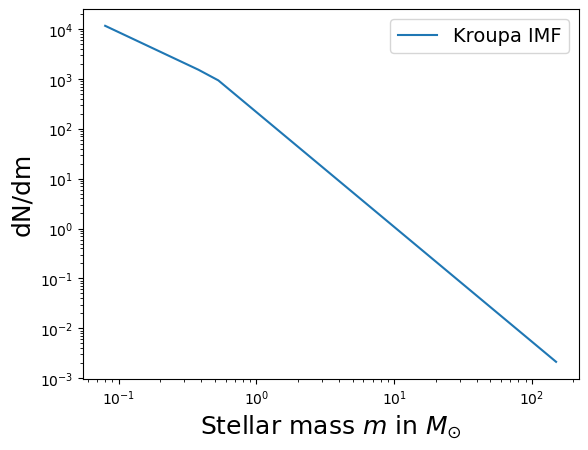

In [5]:
M_ecl=1000
x=np.linspace(0.08,150,1000)

i=0
Kroupa_IMF=np.array([])
while i<len(x):
    Kroupa_IMF=np.append(Kroupa_IMF, IMF(x[i],M_ecl, 150))
    i=i+1

plt.loglog(x, Kroupa_IMF, label='Kroupa IMF')
plt.xlabel(r'Stellar mass $m$ in $M_{\odot}$', size=18)
plt.ylabel(r'dN/dm', size=18)
plt.legend(fontsize=14)

## Draw IMF samples

In [6]:
### Define a canonical IMF
alpha_1_model=0 
alpha_2_model=0
alpha_3_model=0
M_over_H= 0 ## [Z] = [Z/Zsolar] (Metallicity)
M_ecl=10000 ## Mecl in Msolar

m_i_array, M_i_array, totalmass, num_stars, k3, alpha_3, m_max = draw_imf(M_ecl, alpha_1_model, alpha_2_model, alpha_3_model, M_over_H)
## Check the number of drawn stars
print('The cluster contains', len(M_i_array), 'stars ')
print('From integrating over the IMF, it should contain', scipy.integrate.quad(IMF, 0.08, m_max, args=(M_ecl, m_max))[0], 'stars')
## Check the slope of the powerlaws
print(r'The IMF slope for m < 0.5 Msolar is:',MLE_with_std(M_i_array[M_i_array<0.5])[0], '+/-', MLE_with_std(M_i_array[M_i_array<0.5])[1])
print(r'The IMF slope for 0.5 < m < 1 Msolar is:',MLE_with_std(M_i_array[(M_i_array<1) & (M_i_array>0.5)])[0], '+/-', MLE_with_std(M_i_array[(M_i_array<1) & (M_i_array>0.5)])[1])
print(r'The IMF slope for m > 1 Msolar is:',MLE_with_std(M_i_array[M_i_array>1])[0], '+/-', MLE_with_std(M_i_array[M_i_array>1])[1])
print(r'The input high-mass slope (m > 1 Msolar) of the drawn sample is:', alpha_3)

Total mass of cluster: 9999.949728262
The cluster contains 17289 stars 
From integrating over the IMF, it should contain 17289.628375557328 stars
The IMF slope for m < 0.5 Msolar is: 1.3000225838716766 +/- 0.0017344566318100091
The IMF slope for 0.5 < m < 1 Msolar is: 2.3005143427054744 +/- 0.014577336306790116
The IMF slope for m > 1 Msolar is: 2.299868194790461 +/- 0.020539798381343375
The input high-mass slope (m > 1 Msolar) of the drawn sample is: 2.3


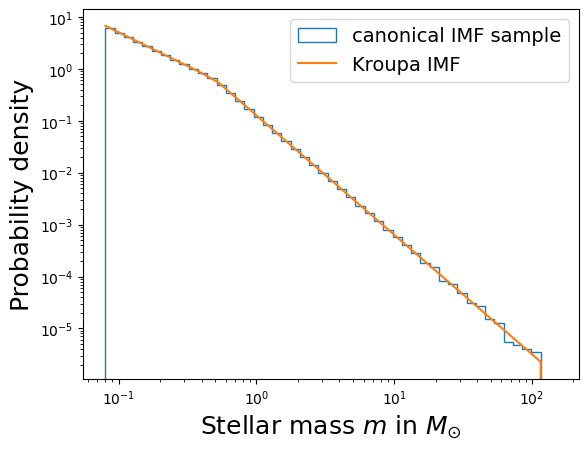

In [7]:
logbins=np.logspace(np.log10(np.min(m_i_array)),np.log10(np.max(m_i_array)), int(len(m_i_array)**(2/5)-1))
plt.hist(M_i_array, bins=logbins, density=True, label='canonical IMF sample', histtype='step')
plt.xscale('log')
plt.yscale('log')

x=np.linspace(0.08,150,1000)
i=0
Kroupa_IMF=np.array([])
while i<len(x):
    Kroupa_IMF=np.append(Kroupa_IMF, IMF(x[i], M_ecl, m_max)/len(M_i_array))
    i=i+1

plt.loglog(x, Kroupa_IMF, label='Kroupa IMF')
plt.xlabel(r'Stellar mass $m$ in $M_{\odot}$', size=18)
plt.ylabel(r'Probability density', size=18)
plt.legend(fontsize=14)

## Comparison between canonical and varying IMF samples

In [8]:
### Define a canonical IMF
alpha_1_model=0
alpha_2_model=0
alpha_3_model=0
M_over_H= 0 ## [Z] = [Z/Zsolar] (Metallicity)
M_ecl=50000 ## Mecl in Msolar

m_i_array, M_i_array_canonical, totalmass, num_stars, k3, alpha_3, m_max_can = draw_imf(M_ecl, alpha_1_model, alpha_2_model, alpha_3_model, M_over_H)

Total mass of cluster: 49999.98198290252


In [9]:
### Define a varying IMF
alpha_1_model='Z' 
alpha_2_model='Z'
alpha_3_model=2
M_over_H= 0 ## [Z] = [Z/Zsolar] (Metallicity)
M_ecl=50000 ## Mecl in Msolar

m_i_array, M_i_array, totalmass, num_stars, k3, alpha_3, m_max = draw_imf(M_ecl, alpha_1_model, alpha_2_model, alpha_3_model, M_over_H)

## Determine the slopes of the IMF sample
print(r'The IMF slope for m < 0.5 Msolar is:',MLE_with_std(M_i_array[M_i_array<0.5])[0], '+/-', MLE_with_std(M_i_array[M_i_array<0.5])[1])
print(r'The IMF slope for 0.5 < m < 1 Msolar is:',MLE_with_std(M_i_array[(M_i_array<1) & (M_i_array>0.5)])[0], '+/-', MLE_with_std(M_i_array[(M_i_array<1) & (M_i_array>0.5)])[1])
print(r'The IMF slope for m > 1 Msolar is:',MLE_with_std(M_i_array[M_i_array>1])[0], '+/-', MLE_with_std(M_i_array[M_i_array>1])[1])
print(r'The input high-mass slope (m > 1 Msolar) of the drawn sample is:', alpha_3)

Total mass of cluster: 49999.92083050335
The IMF slope for m < 0.5 Msolar is: 1.3000063207806707 +/- 0.0009175745405323659
The IMF slope for 0.5 < m < 1 Msolar is: 2.300143951708518 +/- 0.007711245054478664
The IMF slope for m > 1 Msolar is: 2.0551349190969583 +/- 0.008286294764549293
The input high-mass slope (m > 1 Msolar) of the drawn sample is: 2.055124725896406


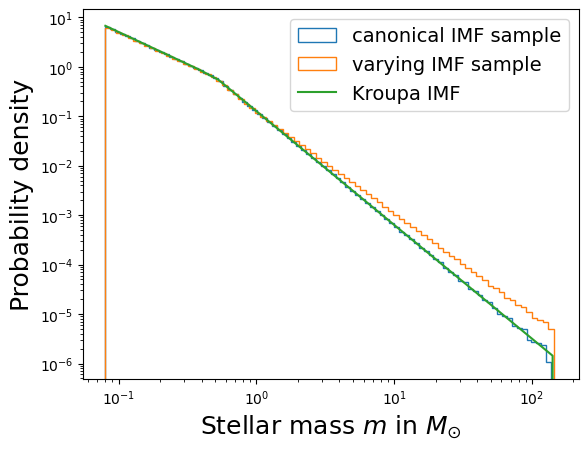

In [10]:
## Plot the samples
logbins=np.logspace(np.log10(np.min(M_i_array_canonical)),np.log10(np.max(M_i_array_canonical)),int(len(M_i_array_canonical)**(2/5)-1))
plt.hist(M_i_array_canonical, bins=logbins, density=True, label='canonical IMF sample', histtype='step')

logbins=np.logspace(np.log10(np.min(M_i_array)),np.log10(np.max(M_i_array)),int(len(M_i_array)**(2/5)-1))
plt.hist(M_i_array, bins=logbins, density=True, label='varying IMF sample', histtype='step')
plt.xscale('log')
plt.yscale('log')

x=np.linspace(0.08,150,1000)
i=0
Kroupa_IMF=np.array([])
while i<len(x):
    Kroupa_IMF=np.append(Kroupa_IMF, IMF(x[i], M_ecl, m_max_can)/len(M_i_array_canonical))
    i=i+1

plt.loglog(x, Kroupa_IMF, label='Kroupa IMF')
plt.xlabel(r'Stellar mass $m$ in $M_{\odot}$', size=18)
plt.ylabel(r'Probability density', size=18)
plt.legend(fontsize=14)

# Special cases

If smaller cluster masses than typically used in the IGIMF Theory are aimed at, the property $m_{\mathrm{max}}$ has to be recalculated. \
For completeness, those cases are shortly presented below.

## Sampling, if $m_{\mathrm{max}}<M_{\mathrm{turn},2}$
If a cluster mass is less than about $2.66\,M_{\odot}$, the $m_{\mathrm{max}}$ value falls below $M_{\mathrm{turn},2}=1\,M_{\odot}$.
In this case the $m_{\mathrm{max}}$ has to be recalculated, though it does not change significantly. 

When dealing with the IGIMF Theory, typically no clusters with masses $< 5\,M_{\odot}$ should appear, so this case is included simply for completeness. 
If you want to check for yourself whether the $m_{\mathrm{max}}$ are actually recalculated, you can comment out the **print('m_max_i=', m_max)** statements within the sampling function.

In [11]:
### Define a varying IMF
alpha_1_model='Z' 
alpha_2_model='Z'
alpha_3_model=2
M_over_H= 0 ## [Z] = [Z/Zsolar] (Metallicity)
M_ecl=2.65 ## Mecl in Msolar

m_i_array, M_i_array, totalmass, num_stars, k3, alpha_3, m_max = draw_imf(M_ecl, alpha_1_model, alpha_2_model, alpha_3_model, M_over_H)

print('m_max=', m_max)
print('The cluster contains only', len(M_i_array), 'stars with masses:\n', M_i_array)

Total mass of cluster: 2.627611982698614
m_max= 0.998308353730049
The cluster contains only 9 stars with masses:
 [0.75063417 0.49725073 0.36815047 0.27992471 0.21732863 0.17177802
 0.13789992 0.11221969 0.09242564]


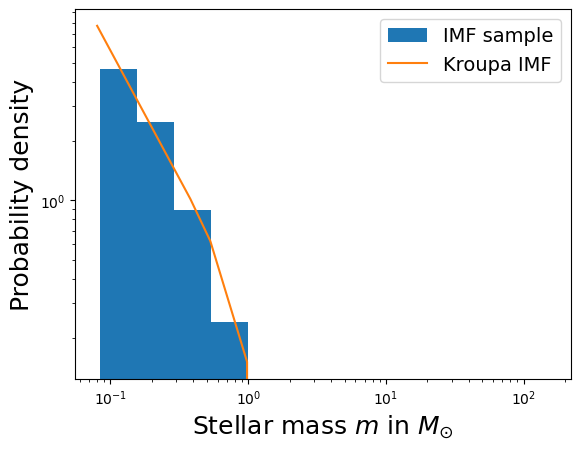

In [12]:
logbins=np.logspace(np.log10(np.min(m_i_array)),np.log10(np.max(m_i_array)),5)
plt.hist(M_i_array, bins=logbins, density=True, label='IMF sample')
plt.xscale('log')
plt.yscale('log')

x=np.linspace(0.08,150,1000)
i=0
Kroupa_IMF=np.array([])
while i<len(x):
    Kroupa_IMF=np.append(Kroupa_IMF, IMF(x[i], M_ecl, m_max)/len(M_i_array))
    i=i+1

plt.loglog(x, Kroupa_IMF, label='Kroupa IMF')
plt.xlabel(r'Stellar mass $m$ in $M_{\odot}$', size=18)
plt.ylabel(r'Probability density', size=18)
plt.legend(fontsize=14)

The number of stars is so small, that no real IMF is visible, but one can at least suspect that the sample follows a canonical Kroupa IMF. This sample only consists of 10 stars, so it is debatable if it even represents a real star cluster due to the small number of stars.

### Sampling, if $m_{\mathrm{max}}<M_{\mathrm{turn}}$

To complete this, if $m_{\mathrm{max}}$ falls below $0.5\,M_{\odot}$ it has to be recalculated another time. Again, the number of drawn stars is so small that it is debatable if the sample would even represent a cluster. This case is typically irrelevant in the IGIMF Theory, as clusters of such small masses do not appear.

In [13]:
### Define a varying IMF
alpha_1_model='Z' 
alpha_2_model='Z'
alpha_3_model=2
M_over_H= 0 ## [Z] = [Z/Zsolar] (Metallicity)
M_ecl=0.65 ## Mecl in Msolar

m_i_array, M_i_array, totalmass, num_stars, k3, alpha_3, m_max = draw_imf(M_ecl, alpha_1_model, alpha_2_model, alpha_3_model, M_over_H)
print('m_max=', m_max)
print('The cluster contains only', len(M_i_array), 'stars with masses:\n', M_i_array)

Total mass of cluster: 0.6417598203133209
m_max= 0.49285101183696367
The cluster contains only 3 stars with masses:
 [0.35002615 0.18414096 0.10759271]
